## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Pindah ke folder yang terdapat dataset
%cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


## Import Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import shutil
import keras
import json
import tempfile
import requests
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
import random
import matplotlib.image as mpimg
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import efficientnet

In [4]:
print(os.listdir("/content/drive/MyDrive/dataset/citra_bisindo"))

['R', 'X', 'Y', 'Z', 'W', 'T', 'V', 'U', 'S', 'Q', 'M', 'J', 'K', 'I', 'G', 'L', 'O', 'P', 'H', 'N', 'A', 'C', 'F', 'E', 'D', 'B']


## Data Load

In [5]:
# Path untuk set pelatihan, validasi, dan pengujian
train_path = "/content/drive/MyDrive/dataset/train"
valid_path = "/content/drive/MyDrive/dataset/val"
test_path = "/content/drive/MyDrive/dataset/test"

# Path data asli
original_data_path = "/content/drive/MyDrive/dataset/citra_bisindo"

In [6]:
# Mendapatkan daftar folder kelas
class_folders = os.listdir(original_data_path)

In [8]:
# Memindahkan data ke folder train, test, dan val
for class_folder in class_folders:
    class_folder_path = os.path.join(original_data_path, class_folder)
    files = os.listdir(class_folder_path)
    train_files, validation_test_files = train_test_split(files, test_size=0.3, random_state=42)

    for file in train_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(train_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    validation_files, test_files = train_test_split(validation_test_files, test_size=0.5, random_state=42)

    for file in test_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(test_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file in validation_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(valid_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [7]:
train_dir = "/content/drive/MyDrive/dataset/train"

unique_labels =  ['R', 'X', 'Y', 'Z', 'W', 'T', 'V', 'U', 'S', 'Q', 'M', 'J', 'K', 'I', 'G', 'L', 'O', 'P', 'H', 'N', 'A', 'C', 'F', 'E', 'D', 'B']


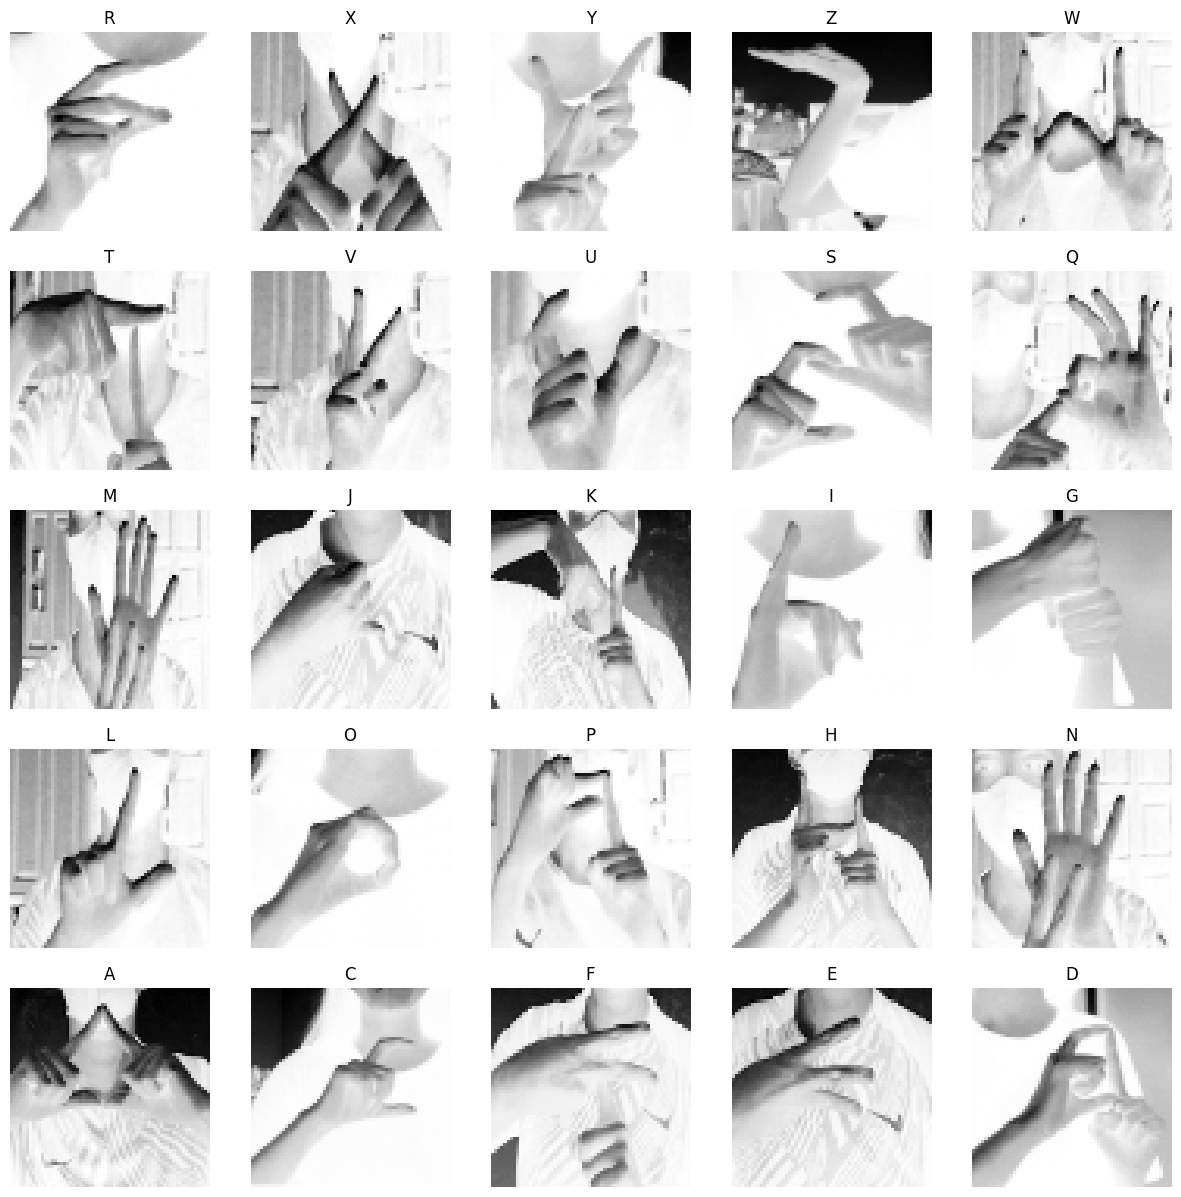

In [8]:
def load_unique():
    size_img = 64,64
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image,cmap='Greys')
    plt.title(label)
    return

image_index = 0
row = 5
col = 5
for i in range(1,(row*col+1)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

## Data Pre-Processing

In [9]:
# Preprocessing data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create data generator objects for training set
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Create data generator objects for validation set
valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Create data generator objects for test set
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 1274 images belonging to 26 classes.
Found 260 images belonging to 26 classes.
Found 286 images belonging to 26 classes.


In [10]:
# Function to count files in a folder
def count_files(folder_path):
    count = sum([len(files) for root, dirs, files in os.walk(folder_path)])
    return count

# Count files in each folder
citra_files = count_files(original_data_path)
train_files = count_files(train_path)
test_files = count_files(test_path)
valid_files = count_files(valid_path)

# Print the counts
print("Number of files in 'citra':", citra_files)
print("Number of files in 'train':", train_files)
print("Number of files in 'test':", test_files)
print("Number of files in 'valid':", valid_files)

Number of files in 'citra': 1820
Number of files in 'train': 1274
Number of files in 'test': 286
Number of files in 'valid': 260


In [60]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])

    images = np.array(images)
    images = images.astype('float32')/255.0

    labels = keras.utils.to_categorical(labels)

    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.12)

    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)

    return X_train, X_test, Y_train, Y_test

In [61]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : R | X | Y | Z | W | T | V | U | S | Q | M | J | K | I | G | L | O | P | H | N | A | C | F | E | D | B | 
Loaded 1121 images for training, Train data shape = (1121, 64, 64, 3)
Loaded 153 images for testing Test data shape = (153, 64, 64, 3)


In [13]:
# Extract a batch of data from the generator
images, labels = next(test_generator)

# Print the shape of the batch of images and labels
print("Shape of images batch:", images.shape)
print("Shape of labels batch:", labels.shape)

Shape of images batch: (32, 256, 256, 3)
Shape of labels batch: (32, 26)


## Model Building

In [14]:
model = Sequential()

model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,3)))
model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = [3,3]))

model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = [3,3]))

model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = [3,3]))

model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(26, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])

print("MODEL CREATED")
model.summary()

MODEL CREATED
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                     

## define the early stopping callback

In [15]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=2)

## KFold

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
#kf= StratifiedKFold(n_splits=3)
kf = KFold(n_splits=3)

In [17]:
def get_score (model, x_train, x_test, y_train, y_test):
    curr_model_hist= model.fit(x_train,y_train, batch_size = 64, callbacks=[es],validation_data=(x_test,y_test),epochs=20)
    test_score = model.evaluate(x_test,y_test)
    train_score = model.evaluate(x_train,y_train)
    plotHistory(curr_model_hist)
    return train_score,test_score

# plot training history

In [18]:
def plotHistory(curr_model_hist):
    plt.plot(curr_model_hist.history['accuracy'])
    plt.plot(curr_model_hist.history['val_accuracy'])
    plt.legend(['train', 'test'], loc='lower right')
    plt.title('accuracy plot - train vs test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

    plt.plot(curr_model_hist.history['loss'])
    plt.plot(curr_model_hist.history['val_loss'])
    plt.legend(['training loss', 'validation loss'], loc = 'upper right')
    plt.title('loss plot - training vs vaidation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

# model training KFoLD

Epoch 1/20
12/12 [==============================] - 13s 947ms/step - loss: 3.9171 - accuracy: 0.0549 - val_loss: 3.8844 - val_accuracy: 0.0428
Epoch 2/20
12/12 [==============================] - 10s 894ms/step - loss: 3.6629 - accuracy: 0.1285 - val_loss: 3.8253 - val_accuracy: 0.0642
Epoch 3/20
12/12 [==============================] - 8s 686ms/step - loss: 3.0823 - accuracy: 0.2878 - val_loss: 3.7500 - val_accuracy: 0.0936
Epoch 4/20
12/12 [==============================] - 10s 889ms/step - loss: 2.4284 - accuracy: 0.4511 - val_loss: 3.6615 - val_accuracy: 0.0722
Epoch 5/20
12/12 [==============================] - 10s 817ms/step - loss: 1.8524 - accuracy: 0.6185 - val_loss: 3.5848 - val_accuracy: 0.0615
Epoch 6/20
12/12 [==============================] - 9s 727ms/step - loss: 1.3587 - accuracy: 0.7644 - val_loss: 3.4476 - val_accuracy: 0.1471
Epoch 7/20
12/12 [==============================] - 10s 896ms/step - loss: 1.1139 - accuracy: 0.8286 - val_loss: 3.3029 - val_accuracy: 0.2005
E

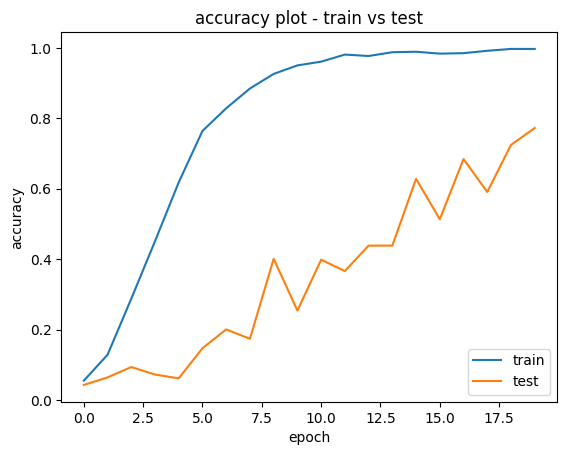

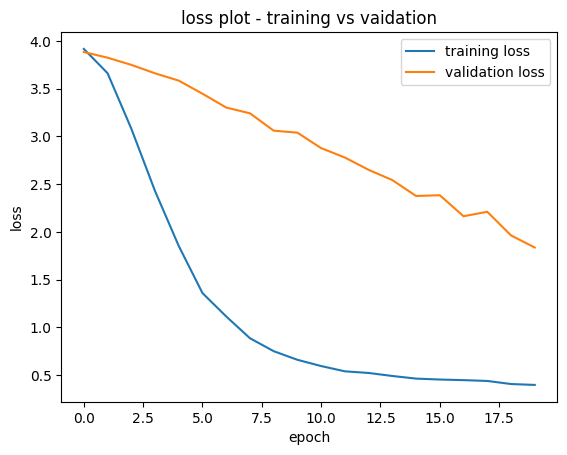

Epoch 1/20
12/12 [==============================] - 10s 887ms/step - loss: 0.7758 - accuracy: 0.8942 - val_loss: 2.4576 - val_accuracy: 0.4385
Epoch 2/20
12/12 [==============================] - 13s 1s/step - loss: 0.6729 - accuracy: 0.8983 - val_loss: 1.7446 - val_accuracy: 0.8396
Epoch 3/20
12/12 [==============================] - 8s 664ms/step - loss: 0.5512 - accuracy: 0.9331 - val_loss: 1.4022 - val_accuracy: 0.9037
Epoch 4/20
12/12 [==============================] - 10s 886ms/step - loss: 0.4854 - accuracy: 0.9612 - val_loss: 1.2411 - val_accuracy: 0.9465
Epoch 5/20
12/12 [==============================] - 10s 850ms/step - loss: 0.4414 - accuracy: 0.9772 - val_loss: 1.4716 - val_accuracy: 0.7086
Epoch 6/20
12/12 [==============================] - 9s 673ms/step - loss: 0.4338 - accuracy: 0.9692 - val_loss: 1.2050 - val_accuracy: 0.7674
Epoch 7/20
12/12 [==============================] - 10s 864ms/step - loss: 0.4001 - accuracy: 0.9826 - val_loss: 0.9400 - val_accuracy: 0.9412
Epoc

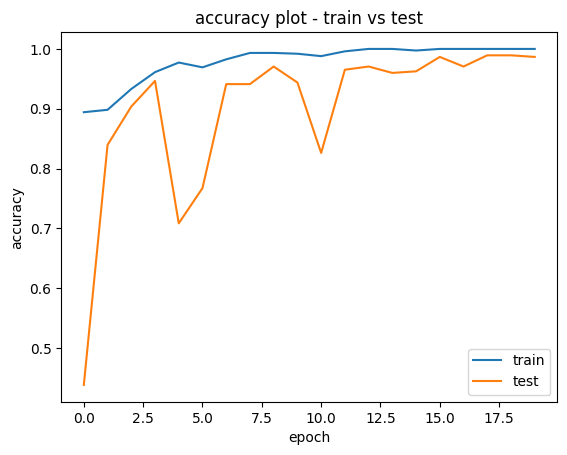

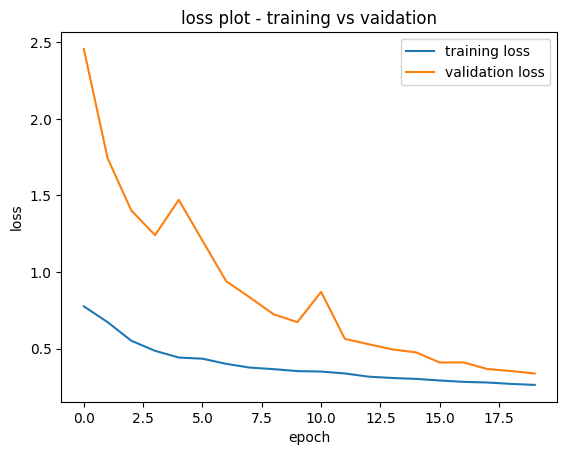

Epoch 1/20
12/12 [==============================] - 10s 877ms/step - loss: 0.3093 - accuracy: 0.9826 - val_loss: 0.3253 - val_accuracy: 0.9866
Epoch 2/20
12/12 [==============================] - 8s 685ms/step - loss: 0.3092 - accuracy: 0.9840 - val_loss: 0.3725 - val_accuracy: 0.9786
Epoch 3/20
12/12 [==============================] - 11s 923ms/step - loss: 0.2879 - accuracy: 0.9853 - val_loss: 0.2835 - val_accuracy: 0.9920
Epoch 4/20
12/12 [==============================] - 10s 813ms/step - loss: 0.2657 - accuracy: 0.9947 - val_loss: 0.2643 - val_accuracy: 1.0000
Epoch 5/20
12/12 [==============================] - 9s 713ms/step - loss: 0.2617 - accuracy: 0.9947 - val_loss: 0.3032 - val_accuracy: 0.9866
Epoch 6/20
12/12 [==============================] - 10s 898ms/step - loss: 0.2532 - accuracy: 0.9947 - val_loss: 0.2735 - val_accuracy: 0.9920
Epoch 6: early stopping
24/24 [==============================] - 3s 140ms/step - loss: 0.2529 - accuracy: 1.0000


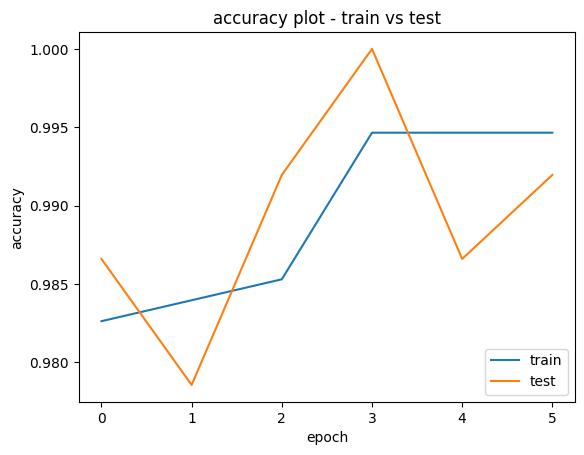

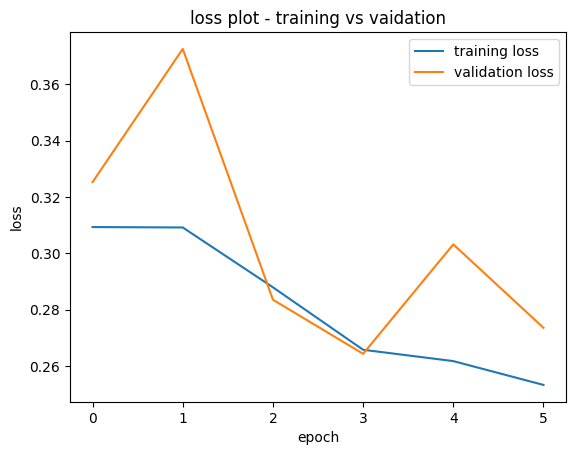

In [20]:
scores = []

for train_index, test_index in kf.split(X_train):
    x_train, x_test, y_train, y_test = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    scores.append(get_score(model,x_train,x_test,y_train,y_test))

In [21]:
scores

[([1.341310739517212, 0.9772422909736633],
  [1.8362289667129517, 0.7727272510528564]),
 ([0.2639071047306061, 1.0], [0.33713269233703613, 0.9866310358047485]),
 ([0.2528557777404785, 1.0], [0.2735130190849304, 0.9919571280479431])]

# calculating the average loss and accuracy

In [35]:
total_train_loss = 0
total_train_acc = 0
total_test_loss = 0
total_test_acc = 0
for i in range (3):
    total_train_loss = total_train_loss+scores[i][0][0]
    total_train_acc =total_train_acc+scores[i][0][1]
    total_test_loss =total_test_loss+scores[i][1][0]
    total_test_acc =total_test_acc+scores[i][1][1]
print(total_train_acc/3)
print(total_train_loss/3)
print(total_test_acc/3)
print(total_test_loss/3)

0.9924140969912211
0.6193578739960989
0.9171051383018494
0.8156248927116394


# Testing the model with test data


In [36]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

5/5 [==============================] - 0s 75ms/step - loss: 0.6318 - accuracy: 0.8954

Evaluation Accuracy =  89.54% 
Evaluation loss =  0.631821


## Evaluate the model with F1 score

In [42]:
def evaluate_F1(model, Y_test, X_test):
    from sklearn.metrics import f1_score
    y_true = [np.where(r == 1)[0][0] for r in Y_test]
    probabilities = model.predict(X_test)
    classes = np.argmax(probabilities, axis=1)
    return f1_score(y_true, classes, average=None)


In [38]:
evaluate_F1(model,Y_test,X_test)

5/5 [==============================] - 1s 111ms/step


array([1.        , 1.        , 0.93333333, 1.        , 1.        ,
       1.        , 0.85714286, 0.93333333, 0.85714286, 1.        ,
       1.        , 0.92307692, 0.82352941, 0.88888889, 0.88888889,
       0.66666667, 0.71428571, 0.76923077, 0.85714286, 1.        ,
       1.        , 1.        , 0.875     , 0.73684211, 0.94117647,
       0.88888889])

In [62]:
model.save('MODEL A.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
